In [352]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error

# **1. Dataset**

In [353]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [354]:
ds = pd.read_csv('/content/drive/MyDrive/colab-notebooks/electric-vehicle-battery-life-prediction/dataset/cleaned_dataset/metadata.csv')
ds # ds.head(10)

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
7560,impedance,[2010. 9. 30. 7. 36. ...,24,B0055,247,7561,07561.csv,NaN,0.0968087979207628,0.15489738203707232
7561,discharge,[2010. 9. 30. 8. 8. ...,4,B0055,248,7562,07562.csv,1.0201379996149256,NaN,NaN
7562,charge,[2010. 9. 30. 8. 48. 54.25],4,B0055,249,7563,07563.csv,NaN,NaN,NaN
7563,discharge,[2010. 9. 30. 11. 50. ...,4,B0055,250,7564,07564.csv,0.9907591663373165,NaN,NaN


In [355]:
ds = ds.drop(columns=['start_time','battery_id','test_id','uid','filename'])

In [356]:
ds.shape  # Dataframe 2D

(7565, 5)

In [357]:
ds[["type", "ambient_temperature"]] # Dataframe 2D

,type,ambient_temperature
0,discharge,4
1,impedance,24
2,charge,4
3,impedance,24
4,discharge,4
...,...,...
7560,impedance,24
7561,discharge,4
7562,charge,4
7563,discharge,4


In [358]:
ds["ambient_temperature"] # series 1D

,ambient_temperature
0,4
1,24
2,4
3,24
4,4
...,...
7560,24
7561,4
7562,4
7563,4


In [359]:
ds["ambient_temperature"][0]

np.int64(4)

In [360]:
ds.isnull().sum()   # check null

,0
type,0
ambient_temperature,0
Capacity,4771
Re,5609
Rct,5609


In [361]:
ds.info() # check kiểu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 7565 non-null   object
 1   ambient_temperature  7565 non-null   int64 
 2   Capacity             2794 non-null   object
 3   Re                   1956 non-null   object
 4   Rct                  1956 non-null   object
dtypes: int64(1), object(4)
memory usage: 295.6+ KB


In [362]:
for col in ds.columns:
    print(ds[col].map(type).value_counts(), '\n')
    print("=====================================")

type
<class 'str'>    7565
Name: count, dtype: int64 

ambient_temperature
<class 'int'>    7565
Name: count, dtype: int64 

Capacity
<class 'float'>    4771
<class 'str'>      2794
Name: count, dtype: int64 

Re
<class 'float'>    5609
<class 'str'>      1956
Name: count, dtype: int64 

Rct
<class 'float'>    5609
<class 'str'>      1956
Name: count, dtype: int64 



# **#. String-columns**

In [363]:
for col in ['type']:
  ds[col] = ds[col].apply(
    lambda val: str(val).strip().lower() if pd.notnull(val) and (str(val).strip().lower() not in ["null", "nan", "n/a", "none"])
    else ""
  )

  # mode
  mode_vals = ds.loc[ds[col] != "", col].mode()
  if not mode_vals.empty:
      ds[col] = ds[col].replace("", mode_vals[0])

In [364]:
ds['type'].value_counts() # xác định encoder

,count
type,
charge,2815
discharge,2794
impedance,1956


In [365]:
type_encoder = OneHotEncoder(sparse_output=False) # encode nhị phân

type_encoded = type_encoder.fit_transform(np.array(ds[['type']])) # fit và transform, return array

type_encoded_df = pd.DataFrame(type_encoded, columns=type_encoder.get_feature_names_out(['type'])) # tạo dataframe

ds = pd.concat([type_encoded_df, ds.drop('type', axis=1)], axis=1) # nối dataframe

# ds[onehot_encoder.get_feature_names_out(['col_name'])] = onehot_encoder.fit_transform(np.array(ds[['col_name']]))
# ds = ds.drop(columns=['col_name'])

In [366]:
ds.head()

,type_charge,type_discharge,type_impedance,ambient_temperature,Capacity,Re,Rct
0,0.0,1.0,0.0,4,1.6743047446975208,NaN,NaN
1,0.0,0.0,1.0,24,NaN,0.05605783343888099,0.20097016584458333
2,1.0,0.0,0.0,4,NaN,NaN,NaN
3,0.0,0.0,1.0,24,NaN,0.05319185850921101,0.16473399914864734
4,0.0,1.0,0.0,4,1.5243662105099023,NaN,NaN


# **#. Number-columns**

In [367]:
for col in ["Capacity", "Re", "Rct"]:
  ds[col] = pd.to_numeric(ds[col], errors='coerce') # invalid thành NaN
  ds[col] = ds[col].fillna(ds[col].median()) # trung vị

# **#. Split**

In [368]:
Y = ds[["ambient_temperature"]]
Y.head()

,ambient_temperature
0,4
1,24
2,4
3,24
4,4


In [369]:
Y.shape # df 2D: (row, column)

(7565, 1)

In [370]:
X = ds.drop(['ambient_temperature'], axis=1)
X.head()

,type_charge,type_discharge,type_impedance,Capacity,Re,Rct
0,0.0,1.0,0.0,1.674305,0.072553,0.101419
1,0.0,0.0,1.0,1.428065,0.056058,0.200970
2,1.0,0.0,0.0,1.428065,0.072553,0.101419
3,0.0,0.0,1.0,1.428065,0.053192,0.164734
4,0.0,1.0,0.0,1.524366,0.072553,0.101419


In [371]:
X.shape # df 2D: (row, column)

(7565, 6)

In [372]:
X_train, X_remain, Y_train, Y_remain = train_test_split(X, Y, test_size=0.15, random_state=123)

remain_length = len(X_remain)
test_length = math.floor(len(X)*0.05)
test_ratio_in_remain = test_length/remain_length

In [373]:
X_val, X_test, Y_val, Y_test = train_test_split(X_remain, Y_remain, test_size=test_ratio_in_remain, random_state=123)

In [374]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

Y_train = Y_train.reset_index(drop=True)
Y_val = Y_val.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

# **#. Scale**
-chia tỉ lệ về [0, 1]

-chỉ scale sau khi đã encode và split

In [375]:
X_scaler = MinMaxScaler() # tính min, max trong từng cột
Y_scaler = MinMaxScaler()

# 2D
X_train = X_scaler.fit_transform(np.array(X_train))  # fit và transform, array
X_val = X_scaler.transform(np.array(X_val))     # transform
X_test = X_scaler.transform(np.array(X_test))   # transform

# 2D
Y_train = Y_scaler.fit_transform(np.array(Y_train))
Y_val = Y_scaler.transform(np.array(Y_val))
Y_test = Y_scaler.transform(np.array(Y_test))

In [376]:
print(f'X_train: \n{X_train[:1]}')
print(f'Y_train: \n{Y_train[:1]}')

X_train: 
[[0.00000000e+00 1.00000000e+00 0.00000000e+00 5.19276643e-01
  1.00000000e+00 1.01763369e-13]]
Y_train: 
[[0.5]]


# **2. Model**

In [377]:
model = Sequential()

# input-layer
model.add(Input(shape=(X_train.shape[1],)))

# hidden-layer (fully-connected), hàm kich hoạt
model.add(Dense(units=64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))  # dropout-layer: tắt 20% ngẫu nhiên số nơ-ron trong mỗi batch để tránh overfitting

model.add(Dense(units=32))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(units=32))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(units=16))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(units=1, activation='relu'))

# output-layer với 1 notron đầu ra, linear: giữ nguyên giá trị đầu ra cho hồi quy
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,707 (18.39 KB)

 Trainable params: 4,419 (17.26 KB)

 Non-trainable params: 288 (1.12 KB)

In [378]:
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True)

history = model.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=500,
                    batch_size=150,
                    callbacks=[early_stop], verbose=1)

Epoch 1/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.2299 - mae: 0.3957 - val_loss: 0.2087 - val_mae: 0.3844
Epoch 2/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1911 - mae: 0.3691 - val_loss: 0.1812 - val_mae: 0.3659
Epoch 3/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1674 - mae: 0.3528 - val_loss: 0.1469 - val_mae: 0.3326
Epoch 4/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1133 - mae: 0.2680 - val_loss: 0.1017 - val_mae: 0.2731
Epoch 5/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0885 - mae: 0.2346 - val_loss: 0.0930 - val_mae: 0.2538
Epoch 6/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0901 - mae: 0.2349 - val_loss: 0.0879 - val_mae: 0.2392
Epoch 7/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0861 - mae: 0.2332 - val_loss: 0.0848 - val_mae: 0.2314
Epoch 8/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0856 - mae: 0.2323 - val_loss: 0.0826 - val_mae: 0.2256
Epoch 9/500
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0

# **3. Save model**

In [379]:
import pickle

pickle_dir_path="/content/drive/MyDrive/colab-notebooks/electric-vehicle-battery-life-prediction/model"

model.save(f"{pickle_dir_path}/model.keras")

with open(f'{pickle_dir_path}/type_encoder.pkl', 'wb') as f1:
    pickle.dump(type_encoder, f1)

with open(f'{pickle_dir_path}/X_scaler.pkl', 'wb') as f2:
    pickle.dump(X_scaler, f2)

with open(f'{pickle_dir_path}/Y_scaler.pkl', 'wb') as f3:
    pickle.dump(Y_scaler, f3)

# **4. Đánh giá**

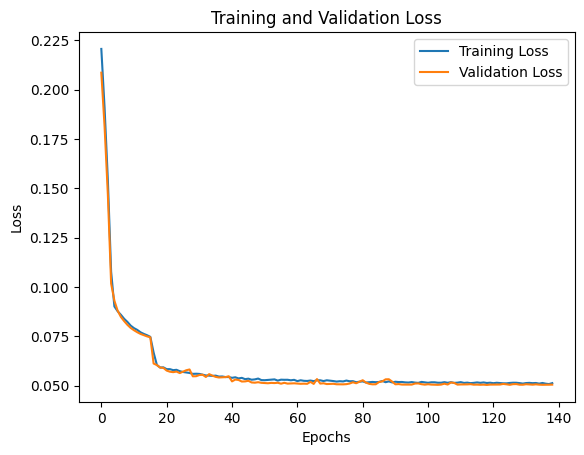

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0508 - mae: 0.1583 
Mean Squared Error on test set: [0.05516825243830681, 0.1657939851284027]


In [380]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

mse = model.evaluate(X_test, Y_test)
print(f'Mean Squared Error on test set: {mse}')

201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


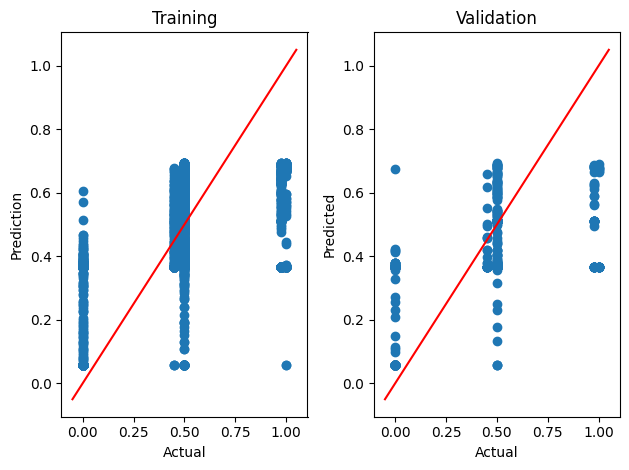

In [381]:
# Specify the dimensions
fig, axes = plt.subplots(1,2)

# This makes the individual subplots
# Training Results
axes[0].scatter(x=Y_train, y=model.predict(X_train))
axes[0].set_xlabel('Actual', fontsize=10)
axes[0].set_ylabel('Prediction', fontsize=10)
axes[0].set_title('Training')

# Add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')

# Validation Results
axes[1].scatter(x=Y_val, y=model.predict(X_val))
axes[1].set_xlabel('Actual', fontsize=10)
axes[1].set_ylabel('Predicted', fontsize=10)
axes[1].set_title('Validation')

# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# Tight layout
fig.tight_layout()
plt.show()

In [382]:
# đánh giá model trên tập test
Y_test_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(Y_test, Y_test_pred))
print("MSE:", mean_squared_error(Y_test, Y_test_pred))
print("MSLE:", mean_squared_log_error(Y_test, Y_test_pred))
print("score :", r2_score(Y_test, Y_test_pred))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MAE: 0.165793982613339
MSE: 0.05516824760566398
MSLE: 0.029754315724872485
score : 0.2961802803658925


# **5. Dự đoán**

In [393]:
X.columns

Index(['type_charge', 'type_discharge', 'type_impedance', 'Capacity', 'Re',
       'Rct'],
      dtype='object')

In [394]:
np.zeros(len(X.columns)) # 1D (6,)

array([0., 0., 0., 0., 0., 0.])

In [395]:
X.columns.get_loc('Capacity')

3

In [396]:
def prepare_input(type_battery, capacity, re, rct):
    X_predict = np.zeros(len(X.columns)).reshape(1, len(X.columns)) # 2D (1, 6)

    # encode
    type_encoded = type_encoder.transform(np.array([[type_battery.lower()]])) # # array(1, 3)

    X_predict[0][X.columns.get_loc('Capacity')] = capacity
    X_predict[0][X.columns.get_loc('Re')] = re
    X_predict[0][X.columns.get_loc('Rct')] = rct

    return X_scaler.transform(X_predict)

In [397]:
def predict_battery_life(**predict_input):
    X_predict = prepare_input(**predict_input)

    # ambient_temperature
    Y_predict = model.predict(X_predict)

    return Y_scaler.inverse_transform(Y_predict)

In [398]:
# 24
Y_predict1 = predict_battery_life(type_battery = 'impedance', capacity = 1.428065, re = 0.053192, rct = 0.164734)

print(f"Predicted Battery Life: {Y_predict1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Battery Life: [[23.878925]]


In [399]:
# 4
Y_predict2 = predict_battery_life(type_battery = 'discharge', capacity = 0.990759, re = 0.072553, rct = 0.101419)

print(f"Predicted Battery Life: {Y_predict2}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Battery Life: [[6.251209]]
